# Chess Winner Prediction Using ML Models 

The goal is to predict chess matches winner using the available data from lichess dataset. And also, what is the impact of the opening (strategy and turns taken) in winning the game. You can inspect and download the dataset from [this url](https://www.kaggle.com/datasets/datasnaek/chess).

**TODO: Improve introduction**

**TODO: understand scikit-learn pipelines. [ref_1](https://scikit-learn.org/stable/modules/compose.html#pipeline), [ref_2](https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9)**

## About Dataset

Extracted from official dataset index.

**General Info**

This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org, and how to collect more. This set contains the following features:


- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, [list here](https://www.365chess.com/eco.php));
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

Data was collected using the [Lichess API](https://github.com/ornicar/lila), which enables collection of any given users game history.

**Possible Uses**

Lots of information is contained within a single chess game, let alone a full dataset of multiple games. It is primarily a game of patterns, and data science is all about detecting patterns in data, which is why chess has been one of the most invested in areas of AI in the past. This dataset collects all of the information available from 20,000 games and presents it in a format that is easy to process for analysis of, for example, what allows a player to win as black or white, how much meta (out-of-game) factors affect a game, the relationship between openings and victory for black and white and more.

## Imports

In [562]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# only on notebooks
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

## Loading, exploring and preprocessing data

In [563]:
chess = pd.read_csv('games.csv')

In [564]:
chess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [565]:
chess.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [566]:
chess.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


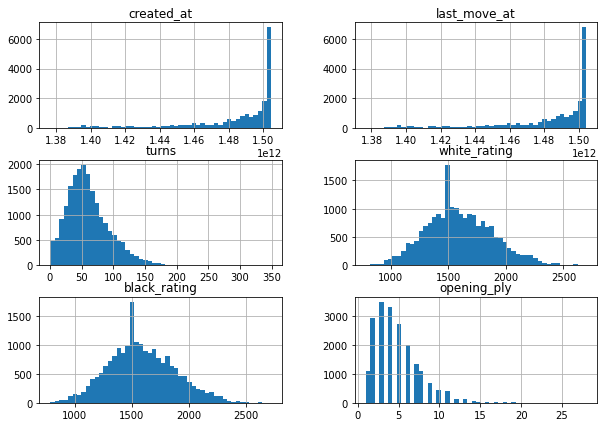

In [567]:
chess.hist(bins=50, figsize=(10,7))
plt.show()

In [568]:
# chess['opening_eco'].unique().size

### Grouping opening ecos by categories

In [569]:
def get_rows_by_opening(df, code):
    return df['opening_eco'][df['opening_eco'].str.startswith(code)]

In [570]:
def group_ecos_by_cat(cat_array, df):
    openings = []
    for cat in cat_array:
        opening = get_rows_by_opening(df, cat)
        openings.append(opening)
    
    for idx, op in enumerate(openings, start=1):
        for row in op:
            df['opening_eco'] = df['opening_eco'].replace(row, idx)
    return df

In [571]:
cat_arr = ['A', 'B', 'C', 'D', 'E']
inverse_cat_arr = ['E', 'D', 'C', 'B', 'A']
# group_ecos_by_cat(inverse_cat_arr, chess)

In [572]:
print(chess['winner'].unique())
print(chess['winner'].unique().size)

['white' 'black' 'draw']
3


In [573]:
print(chess['victory_status'].unique())
print(chess['victory_status'].unique().size)

['outoftime' 'resign' 'mate' 'draw']
4


### One-Hot Encoding Categorical Variables

In [574]:
# https://www.statology.org/one-hot-encoding-in-python/

def cat_encoder(df, var_array):
    encoded, categories = var_array.factorize()
    print('first values: ')
    print(encoded[:10])
    print(categories)
    encoder = OneHotEncoder()
    one_hot = encoder.fit_transform(encoded.reshape(-1, 1))
    one_hot_df = pd.DataFrame(one_hot.toarray())
    return df.join(one_hot_df)

In [575]:
chess = cat_encoder(chess, chess['winner'])

first values: 
[0 1 0 0 0 2 0 1 1 0]
Index(['white', 'black', 'draw'], dtype='object')


In [576]:
# keeping winner bcause its our y
chess.rename({0: 'white_wins', 1: 'black_wins', 2: 'draw'}, axis=1, inplace=True)

Dropping draw column to avoid redundancy

In [577]:
chess.drop(['draw'], axis=1, inplace=True)

In [578]:
print(chess['victory_status'].unique())
print(chess['victory_status'].unique().size)

['outoftime' 'resign' 'mate' 'draw']
4


In [579]:
# chess = cat_encoder(chess, chess['victory_status'])
# chess.drop('victory_status', axis=1, inplace=True)
# chess.rename({0: 'outoftime', 1: 'resign', 2: 'mate', 3: 'draw'}, axis=1, inplace=True)

#### Filling missing data with a constant value

In [580]:
chess['victory_status'] = chess['victory_status'].fillna("resign")

### Further exploring

In [581]:
train_set, test_set = train_test_split(chess, test_size=0.2, random_state=42)

In [582]:
exp_chess = train_set.copy()

In [583]:
corr_matrix = exp_chess.corr()

In [584]:
corr_matrix['white_wins'].sort_values(ascending=False)

white_wins      1.000000
white_rating    0.126157
opening_ply     0.013721
rated           0.004258
created_at     -0.027690
last_move_at   -0.027690
turns          -0.075366
black_rating   -0.171295
black_wins     -0.909616
Name: white_wins, dtype: float64

In [585]:
corr_matrix['black_wins'].sort_values(ascending=False)

black_wins      1.000000
black_rating    0.155364
created_at      0.018253
last_move_at    0.018252
rated           0.008949
turns           0.007362
opening_ply    -0.021261
white_rating   -0.146594
white_wins     -0.909616
Name: black_wins, dtype: float64

#### Exploratory assumptions

* There is no apparent linear relations between features.
* It's easier to win on white side, even if you are outranked by your opponent.
* The most common method to win is ```resign```.
* Black have better chances on longer games, winning by ```outoftime```.
* Simetrically, white have better chances on short ```opening_ply```.
* The longer the game, more chances black have to win.


In [586]:
chess['winner'].value_counts()

white    10001
black     9107
draw       950
Name: winner, dtype: int64

Also, looks like there is no label class inbalance.

Player's ranks difference might be a good indicator of winner. So we will measure it by taking the absolute difference between players.

In [587]:
# chess['elo_diff'] = chess['white_rating'] - chess['black_rating']
# chess['elo_diff'] = chess['elo_diff'].apply(abs)

### Dropping unused columns

Some features, like unique match and player's ```id```, if match was ```rated``` or not, and timestamps are not useful to us. Therefore, they must be removed. Also, ```moves``` can result in some sort of data leakage, and will be removed aswell.

In [588]:
# MY INITIAL PARAMS
# chess = chess.drop(['id', 'rated', 'created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id', 'opening_name', 'moves'], axis=1)

# ZEYNEP PARAMS (BEST)
chess = chess.drop(["id", "created_at", "last_move_at", "increment_code", "white_id", "white_rating", "black_id", "black_rating", "moves", "opening_eco", "opening_name", "opening_ply"], axis=1)

# ZEYNEP PARAMS + ELOS
# chess = chess.drop(["id", "created_at", "last_move_at", "increment_code", "white_id", "black_id", "moves", "opening_eco", "opening_name", "opening_ply"], axis=1)

# ZEYNEP PARAMS + OPENINGS
# chess = chess.drop(["id", "created_at", "last_move_at", "increment_code", "white_id", "white_rating", "black_rating", "black_id", "moves", "opening_name"], axis=1)

### Finishing dataset preprocessing

In [589]:
chess.drop(['white_wins', 'black_wins'], axis=1, inplace=True)

In [590]:
# draws = chess.loc[chess['winner'] == 'draw']
# chess.drop(draws.index, inplace=True)

#### Converting categorical columns

In [591]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
chess['winner'] = LE.fit_transform(chess['winner'])
chess['rated'] = LE.fit_transform(chess['rated'])
chess['victory_status'] = LE.fit_transform(chess['victory_status'])

In [592]:
from sklearn.impute import KNNImputer     #Completing missing data with KNN Algorithm
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
imputer.fit(chess)
chess[:] = imputer.transform(chess)

### Normalization

In [593]:
def normalize(val):
    val = (val-np.min(val))/(np.max(val)-np.min(val))
    return val

In [594]:
# MINE
# features = ['turns', 'white_rating', 'black_rating', 'elo_diff', 'opening_ply']

# ZEYNEP
features = ['turns']

# ZEYNEP + ELO
# features = ['turns', 'white_rating', 'black_rating', 'elo_diff']

# ZEYNEP + OPENINGS
# features = ['turns', 'opening_ply']

for ft in features:
    chess[ft] = normalize(chess[ft])

#### Final dataset status

In [595]:
chess.head()

,rated,turns,victory_status,winner
0,0,0.034483,2,2
1,1,0.043103,3,0
2,1,0.172414,1,2
3,1,0.172414,1,2
4,1,0.270115,1,2


## Splitting Dataset using Holdout Method 

In [596]:
chess_data = chess.loc[:, chess.columns != 'winner']
chess_labels = chess['winner']

In [597]:
X_train, X_test, y_train, y_test = train_test_split(chess_data, chess_labels, test_size=0.30, random_state=42)

### Feature Scaling

Some features range from 0 to 2, while others go from 400 to 2500. This is not ideal because machine learning algorithms could weight them out and give non-existing importance to larger features.

We'll use scikit-learn's ```MinMaxScaler``` to scale our data in the range of zero to one. This is ideal to train neural networks.

In [598]:
min_max_scaler = preprocessing.MinMaxScaler()
std_scaler = preprocessing.StandardScaler()
# X_train[X_train.columns] = min_max_scaler.fit_transform(X_train[X_train.columns])
# X_train[X_train.columns] = std_scaler.fit_transform(X_train[X_train.columns])
# X_train.head()

After fitting scaler to train samples, we can apply to entire dataset.

In [599]:
# X_test[X_test.columns] = min_max_scaler.transform(X_test[X_test.columns])
# X_test[X_test.columns] = std_scaler.transform(X_test[X_test.columns])
# X_test.head()

## Selecting and Training Models

We will evaluate performance using cross validation on the following models:

- K-nearest Neighbors
- Decision Tree
- Naive Bayes
- Support Vector Machine
- Neural Networks

In [600]:
def train_eval_model(model):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    return (train_acc, test_acc)

### K-nearest Neighbors

In [601]:
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p = 2)

knn_3_train_acc, knn_3_test_acc = train_eval_model(knn_model)
print('train accuracy: ', knn_3_train_acc)
print('test accuracy: ', knn_3_test_acc)

train accuracy:  0.8688034188034188
test accuracy:  0.8529411764705882


#### Cross-validation on best K

In [602]:
parameters = {
    'n_neighbors': range(1, 50),
    'metric': ['minkowski'],
    'p': [2]
    }
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)

In [603]:
train_grid_acc, test_grid_acc = train_eval_model(gridsearch)


print('train accuracy: ', train_grid_acc)
print('test accuracy: ', test_grid_acc)

train accuracy:  0.8688034188034188
test accuracy:  0.8529411764705882


In [604]:
gridsearch.best_params_

{'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}

### Decision Tree Classifier

In [605]:
dec_tree = DecisionTreeClassifier()
train_tree_acc, test_tree_acc = train_eval_model(dec_tree)
print('train accuracy: ', train_tree_acc)
print('test accuracy: ', test_tree_acc)

train accuracy:  0.8991452991452992
test accuracy:  0.8958125623130608


### Naive Bayes Classifier

In [606]:
from sklearn.naive_bayes import GaussianNB

gauss_nb_model = GaussianNB()

train_nb_acc, test_nb_acc = train_eval_model(gauss_nb_model)
print('train acc: ', train_nb_acc)
print('test acc: ', test_nb_acc)

train acc:  0.5396011396011396
test acc:  0.5423728813559322


### Neural Network

In [607]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
train_nn_acc, test_nn_acc = train_eval_model(nn_model)
print('train acc: ', train_nn_acc)
print('test acc: ', test_nn_acc)

train acc:  0.5428774928774929
test acc:  0.5458624127617149
